# Functions

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os


import time
from reportlab.lib.enums import TA_JUSTIFY
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch


def cartesian_coord(*arrays):
    grid = np.meshgrid(*arrays)        
    coord_list = [entry.ravel() for entry in grid]
    points = np.vstack(coord_list).T
    return points

def get_available_attr(img_list):
    attr_dict = {}
    for img_dir in img_list:
        for attr in img_dir.split('/')[-2].split('@'):
            attr_name, attr_value = attr.split('(')[0], attr.split('(')[1][:-1]
            if attr_name not in attr_dict.keys():
                attr_dict[attr_name] = [attr_value]
            else:
                if attr_value not in attr_dict[attr_name]: 
                    attr_dict[attr_name].append(attr_value)
    return attr_dict


def filter_results(attr_dict):
    interested_imgs = []
    attrs = []
    attr_names = list(attr_dict.keys())
    attr_list= attr_dict.values()
    
    param_combination_list = cartesian_coord(*attr_list)
    
    for i in range(len(param_combination_list)):
        param_comb= param_combination_list[i]
        
        attrs= []
        for j in range(len(param_comb)):
            attr_name = attr_names[j]
            param_value = param_comb[j]
            attrs.append(f'{attr_name}({param_value})')
            
        #print(attrs)
        for img_dir in img_list:
            flag=True
            for attr in attrs:
                #print('check : ',attr.split('('))
                if attr.split('(')[1][:-1]=='all':
                    flag=True
                    continue
                else:
                    if attr not in img_dir:
                        flag= False
                        break
            if flag==True:interested_imgs.append(img_dir)
            #else:print(img_dir)
    print(f'{len(interested_imgs)} images are found !!!')
    return interested_imgs

def show_results(key, dict_img_position, interested_imgs, sort_by_attr_values=None):
    start, end = dict_img_position[key]

    for img_dir in sorted(interested_imgs, key=sort_by_attr_values):
        plt.figure(figsize = (15,5))
        plt.imshow(plt.imread(img_dir)[start:end,:])
        plt.title(img_dir)
        plt.show()

def sort_name_by_epoch(x):
    return int(x.split('/')[-1].split('_')[0])

def find_last_converged_result(img_dir, loss_threshold=0.05):
    img_list = sorted(glob.glob(f"{img_dir}/*.jpg"),key= sort_name_by_epoch, reverse=True)
    for img_dir in img_list:
        loss= float(img_dir.split('(')[-1][:-5])
        
        img= plt.imread(img_dir)
        is_loss_okay= loss< loss_threshold
        is_results_okay= img[100, 300].sum()< 765

        if is_loss_okay and is_results_okay:
            return img_dir
    
    print(f'####   no image found : {img_dir}')
    return None

def get_metric(img_dir):
    img_name = img_dir.split('/')[-1]
    metrics = img_name[:-4].split('_')[1:]
    metric_dict = {}
    for metric in metrics:
        metric_value = metric.split('(')[1][:-1]
        if metric_value!='nan':metric_value=float(metric_value)
            
        metric_dict[metric.split('(')[0]] = metric_value
    return metric_dict

def find_best_result(img_dir, metric_name='SSIM', metric_type= 'score'): #metric_type= loss/ score
    img_list = sorted(glob.glob(f"{img_dir}/*.jpg"),key= sort_name_by_epoch, reverse=True)
    min_loss=1000
    final_img_dir= None
    
    metric_list=[]
    for img_dir in img_list:
        metric_dict = get_metric(img_dir)
        metric = metric_dict[metric_name]
        if metric!='nan':metric_list.append(metric)
        
    min_metric= min(metric_list)
    max_metric= max(metric_list)
    
    for img_dir in img_list:
        metric_dict = get_metric(img_dir)
        metric = metric_dict[metric_name]
        
        img= plt.imread(img_dir)
        is_results_okay= img[100, 300].sum()< 765
        

        if is_results_okay and metric!='nan':
            #loss= float(loss)
            if metric_type== 'loss':
                if metric<min_metric+0.005:
                    return img_dir
            elif metric_type== 'score':
                if metric>max_metric-0.005:
                    return img_dir
                
            
    print(f'####   no image found : {img_dir}')
    return None

def get_img_list(img_dir = 'figs/mnistv6', mode='L1Loss', loss_threshold=0.05):
    exp_list = sorted(glob.glob(f'{img_dir}/*@*'))
    
    img_dirs=[]
    for idx in range(len(exp_list)):
        #if idx>102:break
        exp_dir = exp_list[idx]
            
        if mode=='last_converged':img_dir = find_last_converged_result(exp_dir, loss_threshold)
        elif mode=='L1Loss':img_dir = find_best_result(exp_dir, metric_name='L1Loss', metric_type= 'loss')
        elif mode=='MSE':img_dir = find_best_result(exp_dir, metric_name='MSE', metric_type= 'loss')
        elif mode=='SSIM':img_dir = find_best_result(exp_dir, metric_name='SSIM', metric_type= 'score')
        elif mode=='SSIM5':img_dir = find_best_result(exp_dir, metric_name='SSIM5', metric_type= 'score')
        elif mode=='SSIM11':img_dir = find_best_result(exp_dir, metric_name='SSIM11', metric_type= 'score')
        
        if idx%100==0:
            print(f'{idx+1}/{len(exp_list)} : {img_dir}')
        
        # exceptions
        #if idx==343:img_dir = find_last_converged_result(exp_dir, 0.130)
        ##
        
        if img_dir==None:
            continue
            
        
        img_dirs.append(img_dir)
    print(f'len img dirs : {len(img_dirs)}')
    return img_dirs
    
    
def sort_by_attr_values(img_dir):
    img_dir= img_dir.split('/')[-2]
    values=[]
    for attr in img_dir.split(')'):
        if attr== '':continue
        values.append(float(attr.split('(')[1]))
    return values



### Save to pdf

In [139]:
def save_imgs2pdf(img_dir_list, sorting_function, pdf_filename, attr_dict=None):
    img_dir_list_sorted = sorted(img_dir_list, key = sorting_function)
    doc = SimpleDocTemplate(pdf_filename,pagesize=letter,
                            rightMargin=72,leftMargin=72,
                            topMargin=72,bottomMargin=18)
    Story=[]
    
    styles=getSampleStyleSheet()
    styles.add(ParagraphStyle(name='Justify', alignment=TA_JUSTIFY))
    
    if attr_dict!=None:
        title = '<font size="25">%s</font>' % "Experiment hyperparameters"
        Story.append(Paragraph(title, styles["Normal"]))
        Story.append(Spacer(1, 50))
        
        for (k, v) in attr_dict.items():
            entry = f'{str(k)} : {str(sorted(v, key= float))}'
            attr = '<font size="15">%s</font>' % entry
            Story.append(Paragraph(attr, styles["Normal"], bulletText='-'))
            Story.append(Spacer(1, 30))
        
        Story.append(PageBreak())
        

    for idx in range(len(img_dir_list)):
        img_name= img_dir_list_sorted[idx]
        
        img_dir_name= img_name.split('/')[-2]
        ptext = '<font size="7">%s</font>' % img_dir_name
        Story.append(Paragraph(ptext, styles["Normal"])) 
        Story.append(Spacer(1, 10))
        
        ptext = '<font size="12">%s</font>' % img_name
        Story.append(Paragraph(ptext, styles["Normal"])) 
        Story.append(Spacer(1, 30))
        
        im = Image(img_name, 8*inch, 8*inch)
        Story.append(im)
        Story.append(PageBreak())
    doc.build(Story)

### Generate heat maps

In [140]:
def create_metric_map(dict_, metric_name='SSIM', interested_key1= 'T', interested_key2 = 'lambda_scale_factor', override_dict= {}):
    for key_ in override_dict:
        dict_[key_] = override_dict[key_]
    
    interested_imgs = filter_results(dict_)
    
    ax1_labels = sorted(dict_[interested_key1], key =float)
    ax2_labels = sorted(dict_[interested_key2], key =float)
            
    metric_map = np.ones((len(ax1_labels),len(ax2_labels)), dtype='float')
    
    def imgdir2metric(img_name):return get_metric(img_name)[metric_name]
    
    for i in range(len(ax1_labels)):
        ax1_vals = ax1_labels[i]
        for j in range(len(ax2_labels)):
            ax2_vals = ax2_labels[j]

            valid_img_dirs=[]
            for img_dir in interested_imgs:
                if f'{interested_key1}({ax1_vals})' in img_dir and f'{interested_key2}({ax2_vals})' in img_dir:valid_img_dirs.append(img_dir)


            sorted_valid_img_dirs= sorted(valid_img_dirs, key= imgdir2metric)
            selected_img_dir = sorted_valid_img_dirs[0]

            metric_dict = get_metric(selected_img_dir)
            metric_map[i, j]= metric_dict[metric_name]
                
    return metric_map, ax1_labels, ax2_labels

def plot_heatmap(metric_map_highlrH, metric_map_lowlrH, vmin, vmax, x_ticks, y_ticks, interested_key1, interested_key2, override_dict, metric_name, save_dir):
    plt.figure(figsize= (15,3))
    plt.subplot(1,2,1)
    ax = sns.heatmap(metric_map_highlrH, linewidth=0.5, annot=True, vmin=vmin, vmax= vmax, fmt= '.5f')
    plt.xticks(np.arange(len(y_ticks))+0.5, y_ticks, rotation=0)
    plt.xlabel(interested_key2)
    plt.yticks(np.arange(len(x_ticks))+0.5, x_ticks, rotation=0)
    plt.ylabel(interested_key1)
    plt.title('Ht is learnable')
    
    plt.subplot(1,2,2)
    ax = sns.heatmap(metric_map_lowlrH, linewidth=0.5, annot=True, vmin=vmin, vmax= vmax, fmt= '.5f')
    plt.xticks(np.arange(len(y_ticks))+0.5, y_ticks, rotation=0)
    plt.xlabel(interested_key2)
    plt.yticks(np.arange(len(x_ticks))+0.5, x_ticks, rotation=0)
    plt.ylabel(interested_key1)
    plt.title('Ht is fixed')
    
    suptit = f'{metric_name} -- '
    overrides= ''
    for key_, val_ in override_dict.items():
        suptit+=f'{key_} : {val_} | '
        overrides += f'{key_}({val_})@'
    
    suptit = suptit[:-3] 
    overrides= overrides[:-1]
    
    plt.suptitle(suptit, y= 1.1)
    
    if save_dir!=None:
        save_dir = f'{save_dir}/heatmaps'
        
        try:os.mkdir(save_dir)
        except:pass
        
        plt.savefig(f'{save_dir}/{metric_name}@@{overrides}.jpg', bbox_inches='tight')
    plt.show()
    
def plot_all_heat_maps(attr_dict_highlrH, attr_dict_lowlrH, interested_key1, interested_key2, override_dict, metric_name= 'SSIM', save_dir =None):
    map_highlrH, xticks_highlrH, yticks_highlrH = create_metric_map(attr_dict_highlrH, metric_name=metric_name, interested_key1= interested_key1, interested_key2 = interested_key2, override_dict= override_dict)
    map_lowlrH, xticks_lowlrH, yticks_lowlrH = create_metric_map(attr_dict_lowlrH, metric_name=metric_name, interested_key1= interested_key1, interested_key2 = interested_key2, override_dict= override_dict)

    
    assert xticks_highlrH== xticks_lowlrH, 'Missing lowLR/ highHR images'
    assert yticks_highlrH== yticks_lowlrH, 'Missing lowLR/ highHR images'

    vmin = min(map_highlrH.min(), map_lowlrH.min())
    vmax =  max(map_highlrH.max(), map_lowlrH.max())

    plot_heatmap(map_highlrH, map_lowlrH, vmin, vmax, xticks_highlrH, yticks_highlrH, interested_key1, interested_key2, override_dict, metric_name, save_dir)

# Summarizing

In [141]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

dict_img_position = {
    'main':[0, 200],
    'ht':[200, 650],
    'loss':[650, 920],
    'overall_results':[930, 1150]}

In [ ]:
img_list

In [148]:
modes = ['L1Loss', 'MSE', 'SSIM', 'SSIM11', 'SSIM5', 'last_converged']
mode = modes[3]
exp_set_dir = 'figs/mnistv9'

img_list = get_img_list(img_dir = exp_set_dir, mode=mode)

print(len(img_list))
get_available_attr(img_list)

1/36 : figs/mnistv9/img_size(64)@T(1)@rotation_lambda(1000.0)@lr_H(0.0)@lambda_scale_factor(1)/85_L1Loss(0.0205812)_MSE(0.0023025)_SSIM11(0.9415638)_SSIM5(0.9179717).jpg
len img dirs : 36
36


{'img_size': ['64'],
 'T': ['1', '16', '2', '32', '4', '8'],
 'rotation_lambda': ['1000.0'],
 'lr_H': ['0.0', '1.0'],
 'lambda_scale_factor': ['1', '2', '3']}

In [149]:
dict_ = {'img_size': ['64'],
 'T': ['1', '16', '2', '32', '4', '8'],
 'rotation_lambda': ['1000.0'],
 'lr_H': ['0.0', '1.0'],
 'lambda_scale_factor': ['1', '2', '3']}

interested_imgs = filter_results(dict_)
print(f'available keys : {list(dict_img_position.keys())}')

36 images are found !!!
available keys : ['main', 'ht', 'loss', 'overall_results']


In [ ]:
show_results('main', dict_img_position, interested_imgs,  sort_by_attr_values)
show_results('loss', dict_img_position, interested_imgs,  sort_by_attr_values)
show_results('ht', dict_img_position, interested_imgs,  sort_by_attr_values)
#show_results('overall_results', dict_img_position, interested_imgs,  sort_by_attr_values)

In [150]:
save_imgs2pdf(interested_imgs, sorting_function= sort_by_attr_values, pdf_filename=f'{exp_set_dir}/_results_summaries/results_{mode}.pdf', attr_dict= dict_)

In [151]:
dict_

{'img_size': ['64'],
 'T': ['1', '16', '2', '32', '4', '8'],
 'rotation_lambda': ['1000.0'],
 'lr_H': ['0.0', '1.0'],
 'lambda_scale_factor': ['1', '2', '3']}

18 images are found !!!
18 images are found !!!


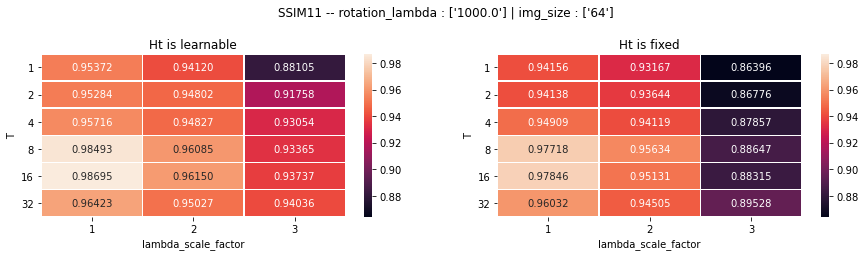

In [152]:
## BELOW attr_dict_highlrH, attr_dict_lowlrH -> ONLY CONTAIN KEYS: lr_H, interested_key1, interested_key2 || Other keys -> goes into override dicts !!!

attr_dict_lowlrH= {'img_size': ['64'],
 'T': ['1', '16', '2', '32', '4', '8'],
 'rotation_lambda': ['1000.0'],
 'lr_H': ['0.0'],
 'lambda_scale_factor': ['1', '2', '3']}

attr_dict_highlrH = {'img_size': ['64'],
 'T': ['1', '16', '2', '32', '4', '8'],
 'rotation_lambda': ['1000.0'],
 'lr_H': ['1.0'],
 'lambda_scale_factor': ['1', '2', '3']}

override_dict=  {'rotation_lambda': ['1000.0'], 'img_size': ['64']}

plot_all_heat_maps(attr_dict_highlrH, attr_dict_lowlrH, interested_key1 = 'T', interested_key2= 'lambda_scale_factor', override_dict=override_dict, metric_name= mode, save_dir =exp_set_dir)

In [159]:
def heatmap_sort_function(heatmap_dir):
    attrs = heatmap_dir[:-4].split('/')[-1].split('@')[2:]
    attrs.reverse()
    
    metric = heatmap_dir[:-4].split('/')[-1].split('@')[0]
    values = [metric]
    for attr in attrs:
        try:values.append(float(attr.split('(')[1][:-1]))
        except:values.append(list(map(float, eval(attr.split('(')[1][:-1]))))
    return values

def save_heatmaps2pdf(heatmap_dir, heatmap_sort_function, pdf_filename):
    heatmap_dir_list= glob.glob(f'{heatmap_dir}/*.jpg')
    heatmap_dir_list_sorted = sorted(heatmap_dir_list, key = heatmap_sort_function)
    doc = SimpleDocTemplate(pdf_filename,pagesize=letter,
                            rightMargin=72,leftMargin=72,
                            topMargin=72,bottomMargin=18)
    Story=[]
    
    styles=getSampleStyleSheet()
    styles.add(ParagraphStyle(name='Justify', alignment=TA_JUSTIFY))
        

    for idx in range(len(heatmap_dir_list_sorted)):
        if idx!=0 and idx%3==0:Story.append(PageBreak())
        img_name= heatmap_dir_list_sorted[idx]
        
        ptext = '<font size="12">%s</font>' % img_name.split('/')[-1]
        Story.append(Paragraph(ptext, styles["Normal"])) 
        Story.append(Spacer(1, 10))
        
        im = Image(img_name, 8*inch, 2*inch)
        Story.append(im)
        Story.append(Spacer(1, 30))
        
    doc.build(Story)

In [160]:
save_heatmaps2pdf(f'{exp_set_dir}/heatmaps', heatmap_sort_function, f'{exp_set_dir}/heatmaps/summary.pdf')